In [1]:
%run Latex_macros.ipynb

<IPython.core.display.Latex object>

In [2]:
# My standard magic !  You will see this in almost all my notebooks.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import neural_net_helper
%aimport neural_net_helper

nnh = neural_net_helper.NN_Helper()
nn_ch = neural_net_helper.Charts_Helper(save_dir="/tmp", visible=False)

In [4]:
# Some figures that we will use in this notebook

# Dot product
fig_dot_prod, ax_dot_prod= plt.subplots(figsize=(20,4))

_=nn_ch.draw_rect(ax_dot_prod, fig_dot_prod, width=0.5, 
                  height=1.5, arrow_width=0.01,
                  labels_in=[ '$x_1$', '$x_2$' ], 
                  labels_out=[ '$y_1 = x \cdot W_1$', "$y_2 = x \cdot W_2$" ],
                  label_bottom="Dot product\nx$ \cdot W$",
                  visible=False
                 )

# Dot product, expanded
fig_dot_prodex, ax_dot_prodex= plt.subplots(figsize=(20,4))

_=nn_ch.draw_rect(ax_dot_prodex, fig_dot_prodex, width=0.5, 
                  height=1.5, arrow_width=0.01,
                  labels_in=[ '$x_1$', '$x_2$' ], 
                  labels_out=[ "$y_1 = x \cdot W_1 = x_1 * W_{1,1} + x_2 * W_{1,2}$", 
                               "$y_2 = x \cdot W_2 = x_1 * W_{2,1} + x_2 * W_{2,2}$" 
                             ],
                  label_bottom="Dot product\nx$ \cdot W$",
                  visible=False
                 )

# Equal weight initialization
fig_eq_wts, ax_eq_wts= plt.subplots(figsize=(20,4))


_=nn_ch.draw_rect(ax_eq_wts, fig_eq_wts, width=0.5, 
                  height=1.5, arrow_width=0.01,
                  labels_in=[ '$x_1$', '$x_2$' ], 
                  labels_out=[ "$y_1 = x \cdot W'$", "$y_2 = x \cdot W'$" ],
                  label_bottom="Dot product\nx$ \cdot W$",
                  visible=False
                 )



/home/kjp/Notebooks/NYU/neural_net_helper.py:379: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = plt.Rectangle((0, 0), width, height, color=color, edgecolor='black')


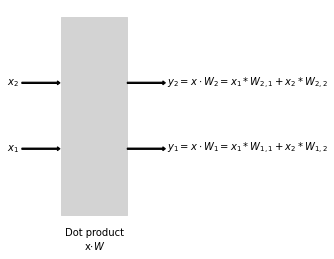

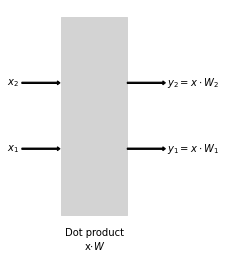

In [5]:
fig_dot_prodex
fig_dot_prod
                              
                              
                            

# Impediments to learning

The updating of weights, used by Gradient Descent to minimize the loss, can be inhibited in less-than-obvious manners.

In this module, we explore these impediments.

This will motivate the creation of a new class of Layer-types: Normalization.

Simply stated: the power of Neural Networks derives largely from
- the non-linear activation functions 
- the simple weight updating of Gradient descent

But these same non-linear activation functions that provide power sometimes interact badly
with Gradient updates.

Let us call the input to the activation function the layer's *pre-activation* value.

For example
- a Fully Connected layer with a ReLU activation
- the *pre-activation* is
    - the dot product of the layer input and Fully Connected layer's weights

Let us examine the plots of the derivatives of the common Activation functions
with respect to the pre-activation values

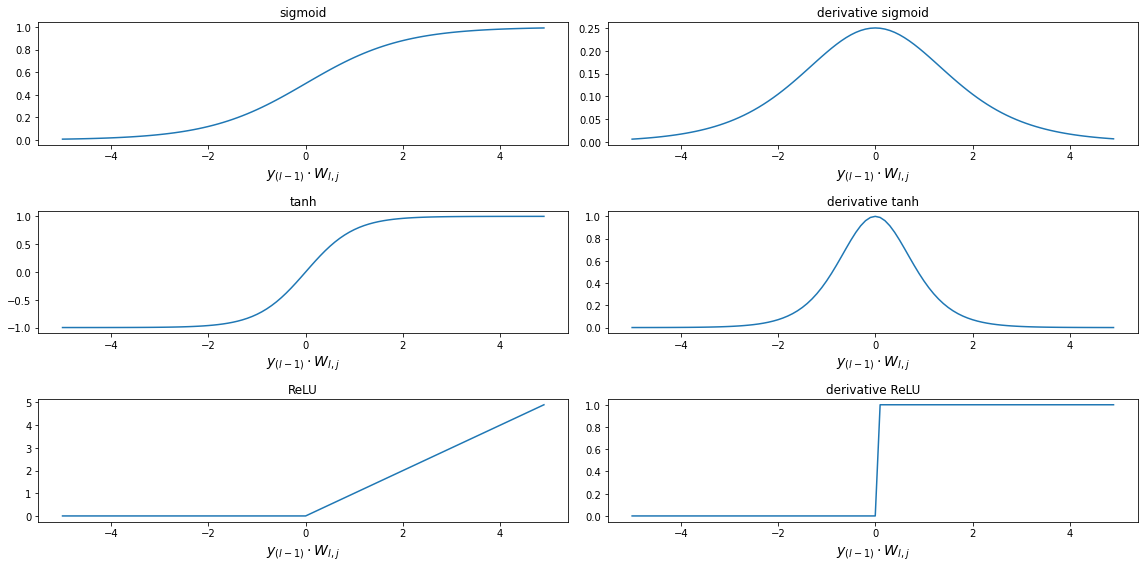

In [6]:
fig, _ = nnh.plot_activations( np.arange(-5,5, 0.1) )

The derivatives of each of these functions has a portion of their domain yielding near zero derivatives.

When the unit that feeds its activation to this Activation function has a value in this domain
- the derivative is zero
- the weight associated with the unit producing this activation will receive a **zero** update from Gradient Descent
    - the unit won't learn


Similarly, there are also portions of the domain with **near-linear** response.

The composition of linear operations is linear, so a deep network without some active non-linearity
loses all its power.

The shaded area of the graph highlights these near-linear regions.

<br>
<br>
<table>
    <tr>
        <th><center>Sigmoid and it derivative<br>Shaded regions indicated second derivative near 0</center></th>
    </tr>
    <tr>
        <td><img src="images/sigmoid_chart.png" width=90%></td>
    </tr>
</table>

The "trick" to successful learning is to ensure that
- the distribution of pre-activations 
- are neither **concentrated** in parts of the domain
    - with zero derivative
    - near-linear response
    
Learning works best when the pre-activation distribution is spread-out rather than "peaky".

This module will highlight how a Neural Network may
- wind up in one of the undesirable situations
- the mechanisms that have been devised to avoid them

# Proper scaling of inputs

We briefly explore the statistical properties of the outputs of a layer.
- We show how some of these properties can inhibit learning (weight update)
- Will motivate the Normalization Layer-type, which will maintain good properties of layer outputs



## Importance of zero centered inputs (for each layer)

**Reference**

[Efficient Backprop paper, LeCunn98](http://yann.lecun.com/exdb/publis/pdf/lecun-98b.pdf)

Batch Gradient Descent has a Loss
- that is the sum of the per-example losses
- of the $m'$ examples in the batch

The  weights of layer $\ll$ are updated in Gradient Descent by the negative of:
$$
\frac{\partial \loss}{\partial \W_\llp}  =  \frac{\partial{\sum_{i=1}^{m'} \loss^\ip}}{\partial \W_\llp} 
$$

###  Examining the update to $\W_{\llp,j}$

Let us look at the term attributable to example $i$:
$$
\begin{array} \\
\frac{\partial \loss^\ip}{\partial \W_\llp} & = & \frac{\partial \loss^\ip}{\partial \y_\llp^\ip} \frac{\partial \y_\llp^\ip}{\partial \W_\llp} & \text{chain rule} \\
\end {array}
$$

The second term $\frac{\partial \y_\llp^\ip}{\partial \W_\llp}$ in the Chain Rule is of interest.

Since $\W_\llp$ is a vector, the derivative wrt $\W_\llp$ is
- a vector
- where element $j$ is $\frac{\partial \y_\llp^\ip}{\partial \W_{\llp,j}}$

$$
\frac{ \partial{\y_\llp^\ip} } { \partial \W_\llp } =
\begin{pmatrix} 
\ldots , \frac{ \partial{\y_\llp^\ip} } { \partial \W_{\llp, j} }, \ldots, 
\end{pmatrix}
$$

For illustration:
- assume layer $\ll$ is a Dense (Fully Connected) Layer with activation function $a_\llp$.

Examining the $j^{th}$ element of the derivative vector:
$$
\begin{array} \\
\frac{ \partial{\y_\llp^\ip} } { \partial \W_{\llp,j} } & = & \frac{ \partial{ a_\llp ( \y^\ip_{(\ll-1)}\cdot \W_\llp ) } } { \partial \W_{\llp,j}} &   \text{  since }  y^\ip_\llp = a_\llp ( \y^\ip_{(\ll-1)} \cdot \W_\llp ) \; \\
& = &  \frac{ \partial{ a_\llp ( \y^\ip_{(\ll-1)}\cdot \W_\llp )} } { \partial (\y^\ip_{(\ll-1)}\cdot \W_{\llp})}
       \frac{ \partial{(\y^\ip_{(\ll-1)}\cdot \W_\llp)} }{ \W_{\llp,j} } & \text{Chain rule} \\
& =& a'_\llp \y^\ip_{(\ll-1),j} & \text{ since } \\
& & &\y^\ip_{(\ll-1)}\cdot \W_\llp = \sum_j { ( \y^\ip_{(\ll-1),j} * \W_{\llp,j} ) }\\
& & & \text{and }  \frac{\partial \sum_j { ( \y^\ip_{(\ll-1),j} * \W_{\llp,j} ) }}{\partial \W_{\llp,j}} = \y^\ip_{(\ll-1),j} \\
 & & & \text{where } a' = \frac{ \partial{ a_\llp ( \y^\ip_{(\ll-1)}\cdot \W_{\llp}) } } { \partial (\y^\ip_{(\ll-1)}\cdot \W_{\llp})}\\
\end{array}
$$

Thus the update to the $j^{th}$ weight $\W_{\llp,j}$ due to example $i$
- is proportional to to the value of *layer input* feature $j$:
$$\y_{(\ll-1),j}$$

Summing over each example $i$ in the batch of $m'$ examples
- the update to  $j^{th}$ weight $\W_{\llp,j}$
- is a weighted (by the value of the activation for example $i$) sum (over the examples in the batch)
    - we will ignore the activation -- it is unimportant for the point we wish to make
- of layer input feature $j$

$$
\frac{\partial \loss}{\partial\W_{\llp,j}} \approx \sum_{i=0}^{m'} {  \y_{(\ll-1),j}^\ip  }
$$


### Distribution of layer input feature $j$

We just showed the update $\W_{\llp,j}$ is influenced by the sum
of the layer's input for feature $j$.

Let use consider a $\W_\llp$ with only 2 features for simplicity.

Gradient Descent can be visualized  as navigating through
- the two-dimensional space of $\W_{\llp,1} \times \W_{\llp,2}$

**The problem with non zero-centered features**

What happens if
- the sign of $\y^\ip_{(\ll-1),1}$ are positive for all $m'$ examples in the batch
- the sign of $\y^\ip_{(\ll-1),2}$ are positive  for all $m'$ examples in the batch

Then the direction of the update of $\W_{\llp,1}$ and $\W_{\llp,2}$ will be the same
- similarly if the signs of all examples for both features is negative




We can show this graphically as moving in the 2D space of $\W_1 \times \W_2$
- update weights at step $\tt$ from $\W_\tp$ to $\W_{(\tt+1)}$
    - confusing notation warning:
        - the subscript here is indexing through the epoch of Gradient Descent
        - we are still referring to the weights of layer $\ll$
- we can move only North-East or South-West

<br>
<br>
<table>
    <center><strong>Weight updates when gradient for each feature has same sign</strong></center>
    <tr>
        <td><center><strong>$W$ update when $\delta \W_1 \gt 0, \delta \W_2 \gt 0$</strong></center></td>
        <td><center><strong>$W$ update when $\delta \W_1 \lt 0, \delta \W_2 \lt 0$</strong></center></td>
    </tr>
    <tr>
        <td><img src="images/grad_updt_ne.png" width=80%></td>
        <td><img src="images/grad_updt_sw.png" width=80%></td>
    </tr>
</table>

But suppose the optimal $\W^*$ is to the South-East of $\W_\tp$
- We can't go there in a single update, because the signs of $\delta \W_1$ and $\delta \W_2$ need to be opposite
- Can only get there *indirectly*
    - sequence of North-East and South-West updates
    
<br>
<br>
<table>
    <center><strong>Weight updates when we need opposite sign for $\delta \W_1, \delta \W_2$n</strong></center>
    <tr>
        <td><img src="images/grad_updt_se.png" width=75%></td>
    </tr>
</table>

We can still get to the optimal $\W^*$
- but through an indirect "zig-zag" path
    - North-East update followed by South-West update
    
This makes Gradient Descent take longer to converge.

### Zero centering each feature

We can avoid the "zig-zag update" problem
- if the signs of the examples in a mini-batch
- are not all the same

A simple way to do this is by **zero centering** the features
- subtracting the mean (across the batch) of feature $j$
- from each example's feature $j$


This is easy to do for Layer $0$
- the Input layer of the network
- zero-center *all* $m$ examples before created batches of size $m$

## Importance of unit variance across features 

Consider a `Dense` (Fully Connected) layer $\ll$.
- each unit computes a dot product
- of the layer inputs $\y_{(\ll-1)}$
- and the weights associated with unit $j$: $\W_{(\ll),j}$
- to compute output $\y_{(\ll),j}$

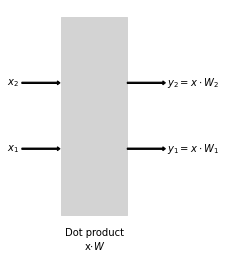

In [7]:
fig_dot_prod

Let's take a look at a property of the dot product
$$
\y_{(\ll),j} = \y_{(\ll-1)} \cdot \W_{(\ll),j} = \sum_{j'=1}^{n_{(\ll-1)}} { \y_{(\ll-1), j'} * \W_{(\ll),j,j'}} 
$$


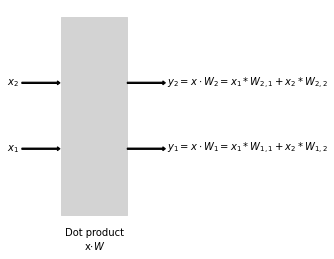

In [8]:
fig_dot_prodex

What is the variance of this sum ?

Let's start by looking at the variance of a single product term in the sum that is the dot product.

Here is that variance

**Statistical Aside** 

The *variance* of a product of random variables $Y, W$ 
[is](https://en.wikipedia.org/wiki/Variance#Product_of_independent_variables)

$$
\text{Var}(Y * W) = \mathbb{E}(Y)^2 \text{Var}(W) + \mathbb{E}(W)^2 \text{Var}(Y) + \text{Var}(Y)\text{Var}(W)
$$

For simplicity: let's assume $\mathbb{E}(Y)$ and $\mathbb{E}(W)$ are both zero.
- for example: we zero-centered the inputs, and initialized weights with mean zero

Then 
$$
\text{Var}(Y * W) = \text{Var}(Y)\text{Var}(W)
$$

For simplicity, let's assume
- each of the features of $\y_\llp$ has identical variance
$$
\text{Var} \left(\y_{(\ll-1), j'} \right) = \sigma^2_\y
$$
- and each of the weights $\W_{(\ll),j,j'}$ has identical variance
$$
\text{Var} \left(\W_{(\ll-1), j, j'} \right) = \sigma^2_\W
$$
- all the terms in the sum are independent

Then, given $n_{(\ll-1)}$ product terms in the dot product
- we get the variance of the dot product as
$$
\text{Var} \left( \sum_{j'=1}^{n_{(\ll-1)}} { \y_{(\ll-1), j'} * \W_{(\ll),j,j'}}  \right) = 
n_{(\ll-1)} * \sigma^2_\y * \sigma^2_\W
$$

Even if
- we had normalized $\y_{(\ll-1)}$ and $\W_\llp$ 
    - so that $\sigma_\y = \sigma_\W = 1$
- the variance of each output feature of layer $\ll$: $\y_{(\ll),j}$
- is greater by a multiplicative factors of $n_{(\ll-1)}$

That is
- even if we have normalized the inputs (Layer 0) 
- **the variance of features in subsequent layers grows**
    - ignoring activation functions
    
The variance of the *pre-activation distribution* grows with the depth of the network.

**The problem with large pre-activation variance**

As the variance of the pre-activation gets larger
- we are more likely to be in one of the extremes of the domain of the Activation function
- where derivatives are often near-zero
- and thus: weights don't get updated during Gradient Descent

Hence, we wind up in an unfavorable region of the Activation function.

**The problem with very small pre-activation variance**

A pre-activation variance that is too small can be problematic too
- there are regions of the activation function that are nearly linear
- if all pre-activation outputs cluster in this region
- we loose the benefit on the non-linearity that the Activation functions provide

# Initialization

Training is all about discovering good weights.

As prosaic as it sounds: how do we *initialize* the weights before training ?
Does it matter ?

It turns out that the choice of initial weights does matter.

We will explain why in this module.
- There is an excellent [visualization tool](https://www.deeplearning.ai/ai-notes/initialization/index.html#playground) to illustrate these concepts
    - Play around with different initialization
    - Visualize the weights, gradients
    
Let's start with some *bad* choices

## Bad choices

### Too big/small

Layers usually consist of linear operations (e.g., matrix multiplication and addition of bias)
followed by a non-linear activation.

The range of many activation functions includes large regions where the derivatives are near zero,
usually corresponding to very large/small activations.

Gradient Descent updates weights using the gradients.

Obviously, if the gradients are all near-0, learning cannot occur.

So one bad choice is any set of weights that tends to push activations to regions of the non-linear
activation with zero gradient.

### Dead Activation functions

This is a special case of a too big/small initialization of the **bias** of a unit.
- our convention is to fold this bias into the weights as element $0$, with corresponding input value $1$
    - exactly as we did for Linear Regression

Recall that a layer's pre-activation value is computed as
- dot product of (some or all) layer inputs and weights
- plus the bias (if not already incorporated in the weight vector)

If the layer learns a very large negative bias
- the pre-activation value will likely be a large negative value
- placing the pre-activation value in a region of the Activation Function with zero gradients
- resulting in no update to the bias

Hence, the negative bias with no updates will persist across training steps.
- the unit will not contribute to distinguishing between input examples

We call a unit with constant (commonly $0$, e.g., ReLU) output
- *saturated*
- *dead* activation

### Identical weights

Consider layer $\ll$ with $n_\ll$ units (neurons) implementing identical operations (e.g. FC + ReLu).

Let  $\W_{\llp, k}$ denote the weights of unit $k$.

Suppose we initialized the weights (and biases) of all units to the *same* vector.
$$
\W_{\llp, k} = \w_\llp, \; 1 \le k \le n_\ll
$$

Consider two neuron $j, j'$ in the same layer $\ll$
$$
\begin{array}[lll]\\
\y_{\llp, j}  & = & a_\llp ( \w_\llp \y_{(\ll-1)} + \b_\llp ) \\
\y_{\llp, j'} & = & a_\llp ( \w_\llp \y_{(\ll-1)} + \b_\llp ) \\
\end{array}
$$

- Both neuron will compute the same activation
- Both neurons will have the same gradient
- Both neurons will have the same weight update
 

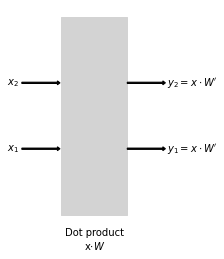

In [9]:
fig_eq_wts

Thus, the weights in layer $i$ will start off identical and will remain identical due to identical updates!

Neurons/units $j$ and $j'$ will never be able to differentiate and come to recognize *different* features.

This negates the advantage of multiple units in a layer.

Many approaches use some for of random initialization to break the symmetry we just described.

This explains the chart we previously saw (training when all weights initialized to zero)
- All weights identical, so no way to break symmetry
- Zero weights lead to zero activation

<img src="images/tnn_loss_and_acc_zero_init.png">

# Maintaining constant variance throughout the layers

Suppose the variance of the features of the input vector for layer $\ll$ (i.e., $\y_{(\ll-1)}$)
- is identical and equal to $\text{Var}$ ($\y_{(\ll-1)}$)

Once it passes through layer $\ll$, what is the output variance $\text{Var}$ ($\y_\llp)$ ?
- which is the variance of the input of layer $\ll+1$.

We can illustrate with an experiment
- a network consisting of a sequence of identically sized Fully Connected layers
- plotting the distribution of layer **outputs** by layer
    - top row: first layer (closest to input)
    - bottom row: deep layer (closest to output)
- through a single epoch: no weight updates

Focus on the title row indicating the mean and standard deviation (std dev)

First, we initialize the layer weights with a relatively large variance ($\sigma = 1$)

<table>
    <tr>
        <th><center>Distribution of  layer outputs (post-activation), by layer (shallow to deep)</center></th>
    </tr>
    <tr>
        <th><center>Random Normal weight initialization</center></th>
    </tr>
    <tr>
        <td><img src="images/tnn_activations_shift_large_var.png"></td>
    </tr>
</table>



The large variance forces the pre-activations toward extreme value.  Hence
- the bimodal peaks for the tanh activation (at the extreme values of `tanh`: -1 and +1
- the large peak of zero values for the ReLU activation (half of ReLU inputs map to 0 outputs)

Note that the variance (for the ReLU) is increasing as we get deeper (top to bottom direction of graphs) into the network

For a very small variance when initializing weights ($\sigma = 0.01$)

<table>
    <tr>
        <th><center>Distribution of layer outputs, by layer (shallow to deep)</center></th>
    </tr>
    <tr>
        <th><center>Random Normal weight initialization</center></th>
    </tr>
    <tr>
        <td><img src="images/tnn_activations_shift_small_var.png"></td>
    </tr>
</table>


The small weight variance causes the pre-activations to tightly cluster for all layers
- standard deviations (reported in title row) are near 0
    - for all layers, for all activations
- these tightly clustered distributions may be centered
    - in regions of the activation function that are near linear
        - mean 0.5 for sigmoid activation
        - mean 0 for tanh activation

## Glorot initialization

Fortunately, there is a simple solution to the exploding pre-activation variance
- initialize the weights $W_\llp$ of Fully Connected layer $\ll$
- to have variance $\frac{1}{n_{(\ll-1)}}$
- by initializing to a unit variance distribution and scaling by 

$$
\frac{1}{\sqrt{n_{(\ll-1)}}}
$$


This forces the dot product to have unit variance

This is the basis for *Glorot/Xavier Initialization*

This only partially solves the problem as it only ensures unit variance of the **input** to the activation function.

If we can make the **output** of the activation also have unit variance then
- the input to each layer is unit variance
- and the output (which is input to the next layer) is also unit variance

Hence the output variance of each activation function remains constant as we proceed through the network.

The [original Glorot paper](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) justifies this
- By assuming either a $\tanh$ or sigmoid activation function
- Which are approximately linear in the active region.
- So the **output** of the activation function is equal to the input in this region
- And is therefore unit variance as desired

Thus far, we have achieved unit variance during the forward pass.

During back propagation
- It can be  shown that the scaling factor
- Depends on the number of outputs $n_\llp$ of layer $\ll$, rather than the number of inputs $n_{(\ll-1)}$
    - because we move from deep to shallow in the backward pass
    - rather than shallow to deep as n the forward pass
- Thus, the scaling factor needs to be $\frac{1}{\sqrt{n_\llp}}$ rather than $\frac{1}{\sqrt{n_{(\ll-1)}}}$

Taking the average of the two scaling factors gives a final factor of
$\frac{1}{\sqrt{ \frac{ n_{(\ll-1)} + n_\llp}{2} } } = \sqrt{\frac{2}{n_{(\ll-1)} + n_\llp}}
$

which is what you often see in papers using this form of initialization.

## Kaiming/He initialization

Glorot/Xavier initialization was tailored to two particular activation functions ($\tanh$ or sigmoid).

[Kaiming et al](https://arxiv.org/pdf/1502.01852.pdf) extended the results
to the ReLU activation.

The ReLU activation has two distinct regions: one linear (for inputs greater than 0) and one all zero.

The linear region of the activation corresponds to the assumption of the Glorot method.

So if inputs to the ReLU are equally distributed around 0, this is approximately the same
as the Glorot method with half the number of inputs.
- that is: half of the ReLU's will be in the active region and half will be in the inactive region.

The Kaiming scaling factor is thus:
$$
\sqrt{\frac{2}{n_{(\ll-1)}} }
$$
in order to preserve unit variance.

## Limits of good initialization

The Glorot and Kaiming/He initializers implicitly assume
- a sequential network: connections only between consecutive layers

It has been observed that, when Residual connections are allowed, the analysis is flawed.

Other techniques (such as Batch Normalization, to be introduced shortly) must be used.

## Layer-wise pre-training

In the early days of Deep Learning
- Before good weight initialization techniques were discovered
- A technique called *Layer-wise pre-training* was very popular

We can motivate this technique by briefly introducing an Autoencoder network.


<table>
    <tr>
        <th><center>Autoencoder</center></th>
    </tr>
    <tr>
        <td>
            <img src="images/Autoencoder_vanilla.png">
        </td>
    </tr>
</table>

An Autoencoder network has two parts
- An Encoder, which takes input $\x$ and "encodes" it into $\z$
- A Decoder, which takes the encoding $\z$ and tries to reproduce $\x$

Each part has its own weights, which can be discovered through training, with examples
- $\langle \X, \y \rangle = \langle \X, \X \rangle$

That is: we are asking the output to be identical to the input.

This will not be possible
when the dimension of $\z$ is less than the dimension of $\x$.
- $\z$ is a *bottle-neck*

$\z$ becomes a *reduced-dimensionality* approximation of $\x$.

This is quite similar to discovering Principal Components.
- We discover a small number of synthetic features $\z$ that summarize the diversity of $\y_{(\ll-1)}$

What does this have to do with layer-wise initialization of weights ?
- We construct an Autoencoder with layer $\ll$ serving the role of the Encoder
- We 
    - train the Autoencoder on layer $\ll$ inputs
    - and subsequently discard the Decoder

The weights for layer $\ll$ obtained from Autoencoder training
- are non-random
- meaningful in the sense that they solve the Autoencoding task
- hopefully transfer to our original task better than random weights



The weights we create
- Are not random, they meet the Autoencoder task objective
- Perhaps non-random weights are better initializers because they discover some structure of the input

Transfer Learning (the subject of another module) works in a similar manner
- Use the weights obtained from training on a Source task
- To use as initial weights for a second Target task

# Batch Normalization Layer

**Reference**

[Batch Normalization paper](https://arxiv.org/abs/1502.03167)

We have motivated the desirability of layer input that have features that are
- zero mean
- unit variance

It is easy to do this for layer $1$
- zero-center the Layer $0$ input $\x$
- weight initialization to preserve unit variance of layer $1$ output

But there is no guarantee that a layer
- with zero-centered inputs for feature $j$
- will have zero-centered outputs for any of its features

In fact, many activation functions
- have *non zero-centered* outputs
- even if all inputs are $0$ !

For example, the value of the Sigmoid with input $0$ is $0.5$.
- guaranteeing that the output is not zero-centered

And the story is similar for variance
- since we used weight initialization to enforce unit variance
- after the first weight update
    - we can't guarantee unit variance for Layer $1$


The solution
- create a new Layer type: *Batch Normalization*
- to normalize the output of a Layer
    - zero mean
    - unit variance


It is called  *batch* normalization because
- the mean and variance used for standardization is computed on a *per batch* basis
- hopefully, each batch's statistics are an approximation of the statistics of the true training distribution

Experimental results show that the technique:
- facilitates the use of much higher learning rates, thus speeding training.  Accuracy is not lost.
- facilitates the use of saturating activations functions (e.g., $\tanh$ and sigmoid) which otherwise are subject to vanishing/exploding gradients.
- acts as a regularizer; reduces the need for Dropout
    - L2 regularization (weight decay) has *no* regularizing effect when used with Batch Normalization !
        - [see](https://arxiv.org/abs/1706.05350)
        - L2 regularization affects scale of weights, and thereby learning rate

## Details

Consider a layer $\ll$ computing
$$
\y_\llp = a_\llp( f_\llp(\y_{(\ll-1)}, W_\llp) )
$$

We use 
- superscript $i$ to denote the value of $\y_\llp$ when the Neural Network input
is example $i$.
- $m_B$ to denote the number of examples in a mini-batch.

Batch Normalization of layer $\ll$ output is defined by the following equations
- producing standardized output $\z^\ip$ 
- rather than unstandardized $\y^\ip$
- given example $i$ as the Neural Network input

$
\begin{split}
1.\quad & \mathbf{\mu}_B = \dfrac{1}{m_B}\sum\limits_{i=1}^{m_B}{\y_\llp^\ip} & \quad  \text{Batch mean}\\
2.\quad & {\mathbf{\sigma}_B}^2 = \dfrac{1}{m_B}\sum\limits_{i=1}^{m_B}{(\y_\llp^\ip - \mathbf{\mu}_B)^2} & \quad \text{Batch variance} \\
3.\quad & \hat\y_\llp^\ip = \dfrac{\y_\llp^\ip - \mathbf{\mu}_B}{\sqrt{{\mathbf{\sigma}_B}^2 + \epsilon}} & \quad \text{Standardize } \y_\llp^\ip\\
4.\quad & \mathbf{z}^\ip = \gamma \hat\y_\llp^\ip + \beta  & \quad \text{De-Standardize } \hat\x^\ip  \text{ with learned mean and variance}\\
\end{split}
$

**Notes**
- The $\epsilon$ in the denominator is there solely to prevent "divide by 0" errors
- The statistics are computed for each feature
    - so $\mu_B$ and $\sigma_B$ are vectors of length $n_\llp$
- Normalization is sometimes defined with respect to 
    - the pre-activation outputs $f_\llp(\y_{(\ll-1)}, W_\llp)$
    - rather than the activation outputs $\y_\llp$
    


The first 3 steps is simple standardization by the mean and variance of the mini-batch.

But: after we obtain standardized $\hat\y_\llp^\ip$ we 
- shift the mean from $0$ to $\beta$
- scale the standard deviation by $\gamma$
- to obtain the final output $\z^\ip$

where $\beta$ and $\gamma$ are **learned parameters**.

What is the point of changing from the distribution to mean $\beta$, variance $\gamma^2$ ?

It can't hurt:
- if the optimal values are $\beta = 0$ and $\gamma = 1$ so that $\z^\ip = \hat\y_\llp^\ip$
    - these are the values that will be learned
- if there is an advantage to the shift: it will be learned    
    - if we are normalizing the pre-activation inputs (rather than the activation outputs)
    - the standardized $\hat\y_\llp^\ip$ may wind up in a linear region of the activation function
    - resulting in a linear transformation
    - shifting may move the result to a non-linear part of the activation function
        - resulting in a non-linear transformation: more powerful


At inference time
- all the parameters ($\mu_B, \sigma_B, \beta, \gamma$) are fixed
- the $\mu_B$ and $\sigma_B$ used for each batch are *identical* across mini-batches
    - are "population" statistics $\mu, \sigma$ computed over the full training dataset
    - usually by a decaying moving average


Keras has a `BatchNormalization` layer type to perform Batch Normalization of its inputs.



Using our running example as illustration
- The following chart shows the effect of adding a `BatchNormalization` layer after the first few `Dense` layers


<table>
    <tr>
        <td><center>RELU</center></td> 
        <td><center>SIGMOID</center></td>
        <td><center>TANH</center></td>
    </tr>
    <tr>
        <td colspan="3">
            <img src="images/tnn_loss_and_acc_bn.png">
    </tr>
</table>

We observe that `BatchNormalization`
- when used on the network with Sigmoid activations
- significantly improves the Loss and Accuracy compared to the network without it
- We can see the output of the `BatchNormalization` layer roughly maintains
    - mean $0$ and unit variance across epochs
    
<table>
    <tr>
        <td><center>RELU</center></td> 
        <td><center>SIGMOID</center></td>
        <td><center>TANH</center></td>
    </tr>
    <tr>
        <td colspan="3">
            <img src="images/tnn_activations_bn.png">
    </tr>
</table>

## Conclusion


Batch Normalization is almost a "magic bullet" for training
- avoids problems caused by covariate shift
- and *also* facilitates higher learning rates
    - accelerating training


There are some theories as to why it enables higher learning rates
- the weights are updated by the product of the learning rate and the derivatives
    - by controlling the size of the derivatives
    - we can use a larger learning rate
    - without increasing the size of the update

- the $\mu_B$ and $\sigma_B$ of each mini-batch are *noisy estimates* of the training set's mean and variance
    - since these values vary by mini-batch, noise is added to training
    - act as a form of regularization
        - forcing the Neural Network's weights to not overly-adapt to each batch
        - similar to the regularization effect seen in Dropout.

## Final words

There are several other common forms of Normalization:
- [Layer Normalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LayerNormalization)
- [Group Normalization](https://www.tensorflow.org/addons/api_docs/python/tfa/layers/GroupNormalization)

In practice, to mitigate the cost to training and inference
- normalization layers are only applied every few layers, not for every layer

There is also some controversy over the wisdom of [using both Batch Normalization and Dropout](https://arxiv.org/pdf/1801.05134.pdf). Essentially:
- Dropout causes the batch statistics computed at training time
- to differ from the population statistics of the training dataset
- which means that the test dataset does not reflect the same distribution as was used in training


## BatchNormalization and Transfer Learning (subtlety)

This is a subtle and technical point involving using
- Pre-trained models
- In Transfer Learning (a subsequent module)

You might want to revisit this section once you start to use Pre-Trained models and Transfer Learning.

Transfer Learning in a nutshell:
- freeze the weights of a Pre-Trained "Base" model that has been trained on a Source Task, using many examples
- train *only* newly added layers in order to adapt the augmented model to a Target task
    - using a *small* number of training examples for the Target Task
- this is an effective way to solve a new Target Task with less effort than training a model from scratch
    - "Transfer" the knowledge encoded in the parameters during training of the Source Task
        - to the Target Task

The issue arises from freezing the base model when it contains normalization layers
- Batch Normalization layers are unique in that they contain *non-trainable* weights
    - in addition to the usual trainable weights
    - the non-trainable weights are the batch statistics
        - computed values, but not part of the trainable weights

The question becomes: what happens to the non-trainable weights during training when the layer is frozen ?

The answer revolves around a technical distinction between *inference mode* and *frozen state*
- "Inference mode" is what happens when the model is not training
    - For `BatchNormalization`: uses the population statistics during *inference*
- "Frozen state" is what happens during training when a layer's weights are frozen; `layer.trainable = False`
    - recall: the batch statistics are *not* trainable weights, so should not be affected by `layer.trainable`
        - might expect batch statistics to always be used
    - For `BatchNormalization`, it was decided instead
        - `layer.trainable = False` means the layer operates in *inference model*
            - even when the model is training (i.e, not performing inference)
        -  results in using the population statistics during *training*
            - rather than batch statistics
    

One reason for this decision
- in Transfer Learning, we usually set `trainable = False` for the *entire model*
    - which recursively sets `trainable = False` for all the model layers
        - including `BatchNormalization`
    - rather than freezing layers individually
    - it is therefore easy to accidentally set `trainable = False` for `BatchNormalization`
    
So the decision was made to treat `trainable = False` for `BatchNormalization` layers
- in a non-standard way
- to capture the user's intent during Transfer Learning

# Conclusion

Maintaining good properties of layer inputs throughout the depth of a multi-layer network
is like priming a pump.

Proper priming helps our learning to flow smoothly.

We explored some of the stumbling blocks to learning (weight update) along with their solutions.

In [10]:
print("Done")

Done
